upload printData.csv


age                         299
anaemia                     299
creatinine_phosphokinase    299
diabetes                    299
ejection_fraction           299
high_blood_pressure         299
platelets                   299
serum_creatinine            299
serum_sodium                299
sex                         299
smoking                     299
time                        299
DEATH_EVENT                 299
dtype: int64
Random Forest Confusion Matrix: 
[[13  2]
 [ 4 11]]

K-neighbor Confusion Matrix
[[13  2]
 [13  2]]

Decision Tree Confusion Matrix:
[[13  2]
 [ 4 11]]


RF accuracy score is:  0.8
K-neighbor accuracy score is:  0.5
Decision-Tree accuracy score is:  0.8
RF Summary
-----------------------------------------------------------------------
Feature:  age  -> feature importance score:  0.07800368965159074
Feature:  anaemia  -> feature importance score:  0.01364467076873129
Feature:  creatinine_phosphokinase  -> feature importance score:  0.08142458202334082
Feature:  diab

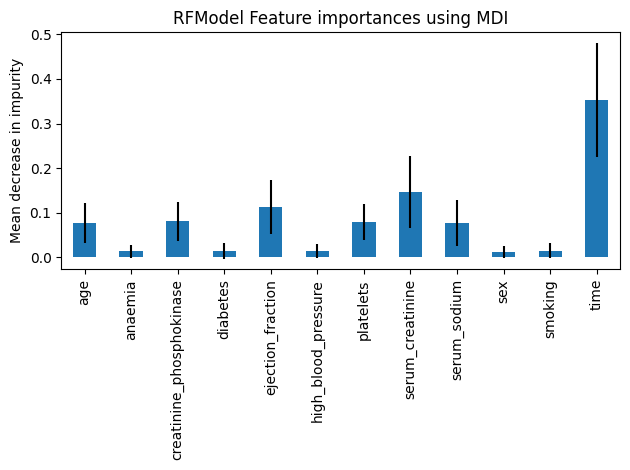

In [33]:
import csv
import pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import os
from google.colab import files
from sklearn.inspection import permutation_importance
from pandas import DataFrame
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean


#compare Random Forest, K-Nearest, Decision Tree


print("upload printData.csv")
files.upload()

processedData = pd.read_csv("dataset.csv")
#shuffle the data to remove any dependency on the order of certain keys/values
#the 'time' value was in order and seemed to carry an odd amount of feature importance -> shuffling the data to try and get rid of that bias
shuffledData = processedData.sample(frac=1)
print(shuffledData.count())
# shuffledData.to_csv("shuffledData.csv", index=False)
# files.download("shuffledData.csv")
dataDict = shuffledData.to_dict()
keyArray = []
for key in dataDict:
  keyArray.append(key)

#create instance of standard scaler, fit the scaler with the shuffled training data
#used to standardize the mean & variation within the data -> "scaling to unit variance"
#creates more normally distributed data so the estimators within each model behave with more accurate performance
#if one feature has too large of a variance, it may "distract" the model, hurting its ability to learn from the rest of the data
scaler = StandardScaler().set_output(transform="pandas")

#trying to use the scaler to fit the shuffled data and create a standardized version to train the model on -> did not seem to have an effect on performance.
#produces 'data is continuous' error once we fit the models -> replaced with the Pipeline function
#now just use the scaledDataFrame to describe the scaled data and detect any differences in the model's performance
scaler.fit(shuffledData)
scaledData = scaler.transform(shuffledData)
scaledDataFrame = DataFrame(scaledData)

#split the data into training/validation sets, X being every key/value that is not DEATH_EVENT and y being the DEATH_EVENT values since that is our target/predicted value
X = shuffledData.drop(['DEATH_EVENT'], axis=1)
y = shuffledData['DEATH_EVENT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1)


# generate descriptive stats on each dataset to gain insight on any patterns, outliers, potential bias, etc
# print("Statistical Analysis of the Input Data: ")
# print("---------------------------------------------------")
# shuffledData.hist()
# plt.show()
# print(shuffledData.describe())
# print()

# print("Statistical Analysis of the Scaled Data: ")
# print("---------------------------------------------------")
# print(scaledDataFrame.describe())
# scaledDataFrame.hist()
# plt.show()
# print()

#declare instances of each model type
RFModel = RandomForestClassifier(n_estimators=200)
KModel = KNeighborsClassifier(algorithm='kd_tree')
DTModel = DecisionTreeClassifier(criterion='entropy')

#fit each model to the original data after being split
RFModel.fit(X_train, y_train)
KModel.fit(X_train, y_train)
DTModel.fit(X_train, y_train)

#convert the expected test values into an array for iteration access in the print loop
y_array = y_test.array

#use each trained model to predict the DEATH_EVENT value on the validation data
RFpredictions = RFModel.predict(X_test)
RFmatrix = confusion_matrix(y_array, RFpredictions)
print("Random Forest Confusion Matrix: ")
print(RFmatrix)
print()
# print("RF Model's Predictions:")
# RFcount=0
# for pred in RFpredictions:
#   print("prediction is: ", pred, " Expected value is: ", y_array[RFcount])
#   RFcount+=1

# print()

# #confusion matrices = [TN FN
#                     #  FP TP]

Kpredictions = KModel.predict(X_test)
Kmatrix = confusion_matrix(y_array, Kpredictions)
print("K-neighbor Confusion Matrix")
print(Kmatrix)
print()
# print("K-Nearest Model's Predictions:")
# Kcount=0
# for pred in Kpredictions:
#   print("prediction is: ", pred, " Expected value is: ", y_array[Kcount])
#   Kcount+=1

# print()

DTpredictions = DTModel.predict(X_test)
DTmatrix = confusion_matrix(y_array, DTpredictions)
print("Decision Tree Confusion Matrix:")
print(DTmatrix)
print()
# DTcount=0
# print("Decision Tree Model's Predictions:")
# for pred in DTpredictions:
#   print("Prediction is: ", pred, " Expected value is: ", y_array[DTcount])
#   DTcount+=1


print()
#display the accuracy of each model, comparing the expected values in y_test with each model's predictions
print("RF accuracy score is: ", accuracy_score(y_test, RFpredictions))
print("K-neighbor accuracy score is: ", accuracy_score(y_test, Kpredictions))
print("Decision-Tree accuracy score is: ", accuracy_score(y_test, DTpredictions))


# create analytical summaries for each model
# focusing on both feature importance and permutation importance -> permutation_importance is only an option for the RF and DT models

print("RF Summary")
print("-----------------------------------------------------------------------")
RFfeatures = RFModel.feature_importances_
i=0
for feature in RFfeatures:
  print("Feature: ", keyArray[i], " -> feature importance score: ", feature)
  i+=1
RFimportance = permutation_importance(RFModel, X, y)
RFImportanceArray = RFimportance["importances"]
print()
print("Permutation Importances for RFModel:")
print()
i=0
for imp in RFImportanceArray:
    print("Feature: ", keyArray[i], " -> feature importance score: ", imp)
    i+=1

#create a graph to display the feature importance of the RF model -> only the RF model has this method
std = np.std([tree.feature_importances_ for tree in RFModel.estimators_], axis=0)
RFImportancesPD = pd.Series(RFfeatures, index=keyArray[0:12])

fig, ax = plt.subplots()
RFImportancesPD.plot.bar(yerr=std, ax=ax)
ax.set_title("RFModel Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

print()
print("K Summary")
print("-----------------------------------------------------------------------")
# Kfeatures = KModel.feature_importances_
# i=0
# for feature in Kfeatures:
#   print("Feature: ", keyArray[i], " -> feature importance score: ", feature)
#   i+=1

print()
print("DT Summary")
print("-----------------------------------------------------------------------")
DTfeatures = DTModel.feature_importances_
i=0
for feature in DTfeatures:
  print("Feature: ", keyArray[i], " -> feature importance score: ", feature)
  i+=1
DTimportance = permutation_importance(DTModel, X, y)
DTImportanceArray = DTimportance["importances"]
print()
print("Permutation Importances for DTModel:")
print()
i=0
for imp in DTImportanceArray:
    print("Feature: ", keyArray[i], " -> feature importance score: ", imp)
    i+=1

print()
print("Beginning Scaled Analysis")
print("--------------------------------------------------------------")

#using the Standard Scaler to standardize the data
procDataVals = shuffledData.values

# separate into input and output columns
scaledX = procDataVals[:, :-1]
scaledY = procDataVals[:, -1]
# ensure inputs are floats and output is an integer label
scaledX = scaledX.astype('float32')
scaledY = LabelEncoder().fit_transform(scaledY.astype('str'))
#create new train/validation splits and use the Pipeline function to fit each model to the new standardized data
scaledX_train, scaledX_test, scaledY_train, scaledY_test = train_test_split(scaledX, scaledY, test_size=.1)


#declare instance of our scaler and pipeline
RFpipeline = Pipeline(steps=[('t', scaler), ('m', RFModel)])
RFpipeline = RFpipeline.fit(scaledX_train, scaledY_train)
# evaluate the pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
RF_scores = cross_val_score(RFpipeline, scaledX, scaledY, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report pipeline performance
RFsum = 0
for score in RF_scores:
  RFsum+=score
print("Average Accuracy Score for Scaled Random Forest Model: ", RFsum/len(RF_scores))
print()

#declare instance of our scaler and pipeline
Kpipeline = Pipeline(steps=[('t', scaler), ('m', KModel)])
Kpipeline = Kpipeline.fit(scaledX_train, scaledY_train)
# evaluate the pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#get accuracy scores of each standardized model (each model's accuracy is an average of 10 iterations)
K_scores = cross_val_score(Kpipeline, scaledX, scaledY, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report pipeline performance
Ksum = 0
for score in K_scores:
  Ksum+=score
print("Average Accuracy Score for Scaled K-Neighbor Model: ", Ksum/len(K_scores))
print()


#declare instance of our scaler and pipeline
DTpipeline = Pipeline(steps=[('t', scaler), ('m', DTModel)])
DTpipeline = DTpipeline.fit(scaledX_train, scaledY_train)
# evaluate the pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
DT_scores = cross_val_score(DTpipeline, scaledX, scaledY, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report pipeline performance
Ksum = 0
for score in DT_scores:
  Ksum+=score
print("Average Accuracy Score for Scaled Decision Tree Model: ", Ksum/len(DT_scores))






#FAILED/OLD CODE-----------------------------------------------------------------------------

# RFScaledModel = RandomForestClassifier()
# KScaledModel = KNeighborsClassifier()
# DTScaledModel = DecisionTreeClassifier()

# RFScaledModel.fit(scaledX_train, scaledY_train)
# KScaledModel.fit(scaledX_train, scaledY_train)
# DTScaledModel.fit(scaledX_train, scaledY_train)


# scaledY_array = scaledY_test.tolist

# RFScaledPredictions = RFScaledModel.predict(scaledX_test)
# # RFScaledMatrix = confusion_matrix(scaledY_array, RFScaledPredictions)
# # print("Scaled Random Forest Confusion Matrix: ")
# # print(RFScaledMatrix)
# print()
# print("RF Model's Scaled Predictions:")
# RFcount=0
# for pred in RFScaledPredictions:
#   print("prediction is: ", pred, " Expected value is: ", scaledY_array[RFcount])
#   RFcount+=1

# print()

# #confusion matrices = [TN FN
#                     #  FP TP]

# KScaledPredictions = KScaledModel.predict(scaledX_test)
# KScaledMatrix = confusion_matrix(scaledY_array, KScaledPredictions)
# print("Scaled K-neighbor Confusion Matrix")
# print(KScaledMatrix)
# print()
# print("K-Nearest Model's Scaled Predictions:")
# Kcount=0
# for pred in KScaledPredictions:
#   print("prediction is: ", pred, " Expected value is: ", scaledY_array[Kcount])
#   Kcount+=1

# print()

# DTScaledPredictions = DTScaledModel.predict(scaledX_test)
# DTScaledMatrix = confusion_matrix(scaledY_array, DTScaledPredictions)
# print("Scaled Decision Tree Confusion Matrix:")
# print(DTScaledMatrix)
# print()
# DTcount=0
# print("Decision Tree Model's Scaled Predictions:")
# for pred in DTScaledPredictions:
#   print("Prediction is: ", pred, " Expected value is: ", scaledY_array[DTcount])
#   DTcount+=1


# print()
# #returns fraction of correctly classified samples
# print("Scaled RF accuracy score is: ", accuracy_score(scaledY_test, RFScaledPredictions))
# print("Scaled K-neighbor accuracy score is: ", accuracy_score(scaledY_test, KScaledPredictions))
# print("Scaled Decision-Tree accuracy score is: ", accuracy_score(scaledY_test, DTScaledPredictions))










Average Accuracies during 10% test size from 5 iterations:
---------------------------------------------
Average accuracy of RF is:  0.8500000000000001
Average accuracy of K is:  0.6666666666666666
Average accuracy of DT is:  0.7111111111111111
Average accuracy of RF_scaled is:  0.8447765006385696
Average accuracy of K_scaled is:  0.7376500638569602
Average accuracy of DT_scaled is:  0.7772094508301405


Average Accuracies during 20% test size from 5 iterations:
---------------------------------------------
Average accuracy of RF is:  0.8611111111111112
Average accuracy of K is:  0.6277777777777778
Average accuracy of DT_20_accuracy is:  0.8444444444444444
Average accuracy of RF_20_scaled_accuracy is:  0.8084649122807016
Average accuracy of K_20_scaled_accuracy is:  0.6691666666666668
Average accuracy of DT_20_scaled_accuracy is:  0.7167543859649124

Average Standard Deviation of Accuracy during 10% test size from 5 iterations:
---------------------------------------------
Standard De

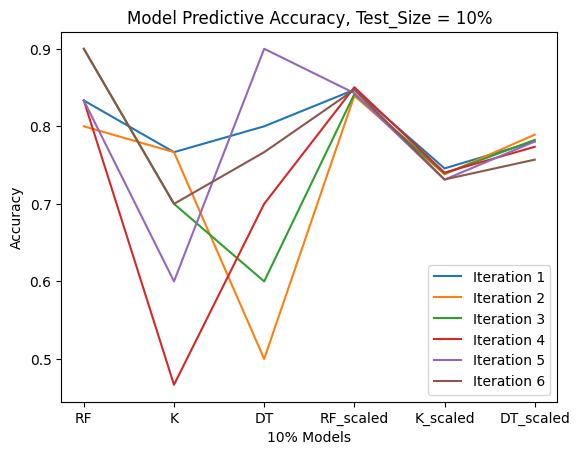

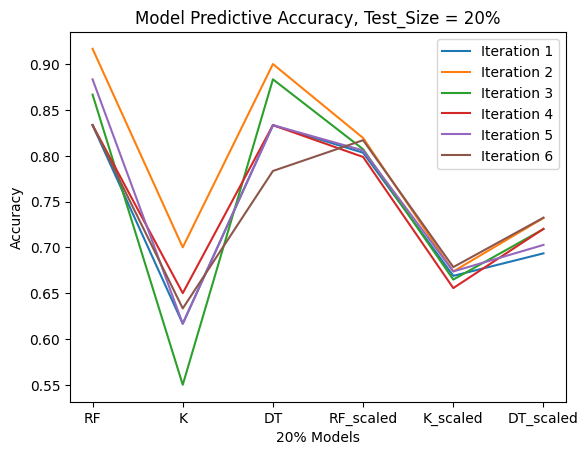

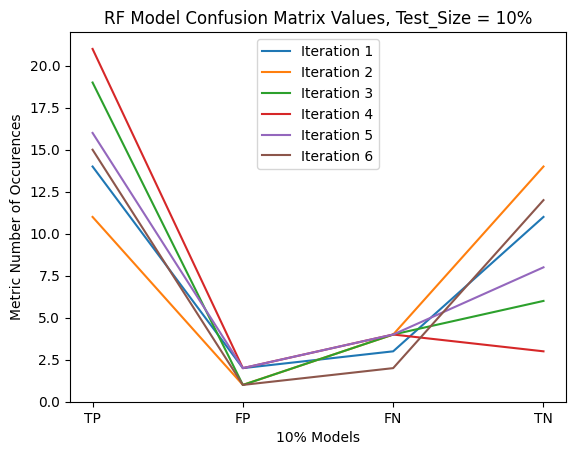

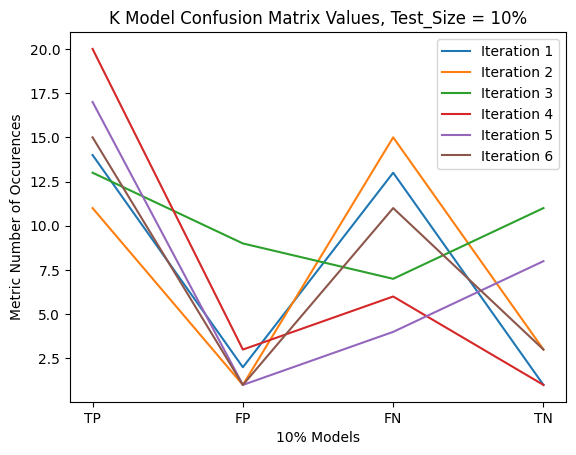

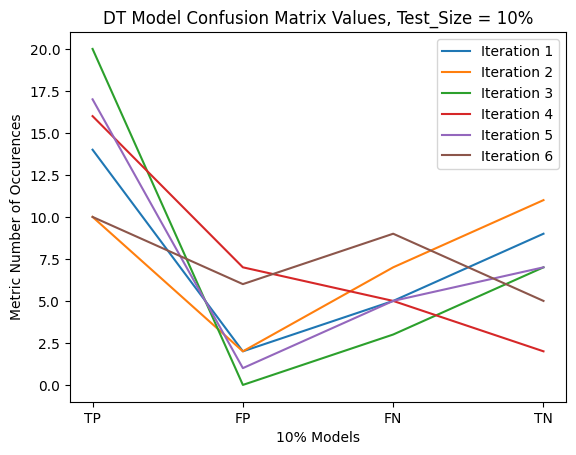

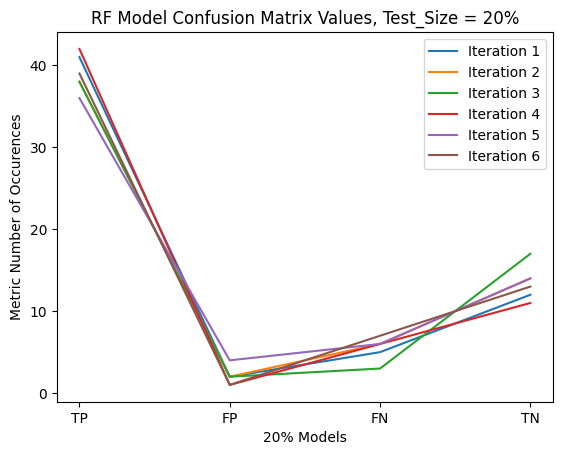

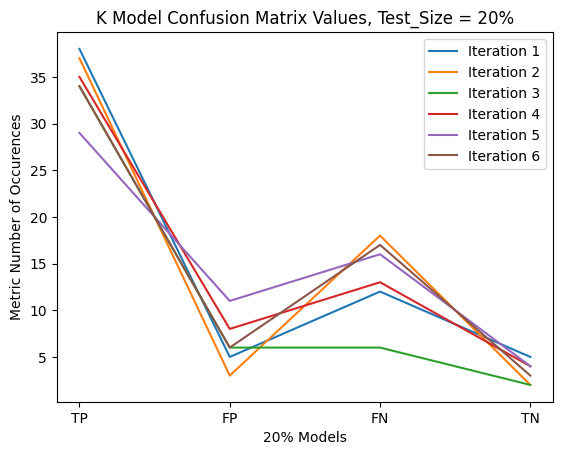

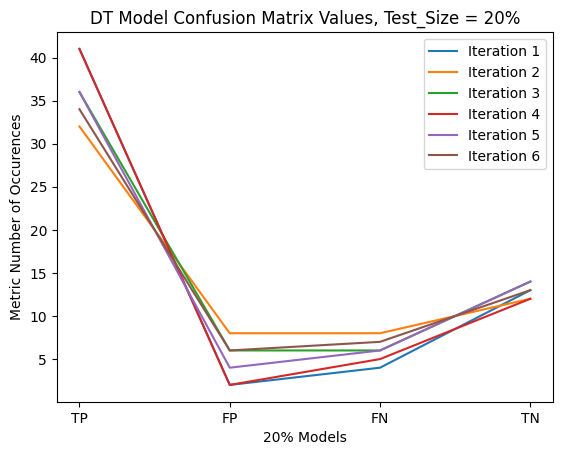

In [32]:
import statistics
import matplotlib.pyplot as plt


#10% CMs:
RFTP = [14, 11, 19, 21, 16, 15]
RFFP=[2, 1, 1, 2, 2, 1]
RFFN=[3, 4, 4, 4, 4, 2]
RFTN=[11, 14, 6, 3, 8, 12]

KTP=[14, 11, 13, 20, 17, 15]
KFP=[2, 1, 9, 3, 1, 1]
KFN=[13, 15, 7, 6, 4, 11]
KTN=[1, 3, 11, 1, 8, 3]

DTTP=[14, 10, 20, 16, 17, 10]
DTFP=[2, 2, 0, 7, 1, 6]
DTFN=[5, 7, 3, 5, 5, 9]
DTTN=[9, 11, 7, 2, 7, 5]

#Test Size: 10%

RF_10_accuracy = [0.8333333333333334, .8, .9, 0.8333333333333334, .8333333333333334, .9]

K_10_accuracy  = [0.7666666666666667, 0.7666666666666667, .7, 0.4666666666666667, .6, .7]

DT_10_accuracy = [.8, .5, .6, .7, .9,  0.7666666666666667]

RF_10_scaled_accuracy = [0.8471264367816093,  0.8393869731800768, 0.8416858237547892, 0.8504597701149424, 0.8427969348659003, 0.8472030651340996]

K_10_scaled_accuracy = [0.7457088122605363, 0.7380842911877395, 0.7391570881226053, 0.7402681992337163, 0.7312260536398466, 0.7314559386973178]

DT_10_scaled_accuracy = [0.7805363984674331, 0.7892337164750957,  0.7824904214559388, 0.7736015325670498, 0.7803831417624522, 0.7570114942528736]




#20% CMs:
RF20TP=[41, 38, 38, 42, 36, 39]
RF20FP=[2, 2, 2, 1, 4, 1]
RF20FN=[5, 6, 3, 6, 6, 7]
RF20TN=[12, 14, 17, 11, 14, 13]

K20TP=[38, 37, 34, 35, 29, 34]
K20FP=[5, 3, 6, 8, 11, 6]
K20FN=[12, 18, 6, 13, 16, 17]
K20TN=[5, 2, 2, 4, 4, 3]

DT20TP = [41, 32, 36, 41, 36, 34]
DT20FP = [2, 8, 6, 2, 4, 6]
DT20FN = [4, 8, 6, 5, 6, 7]
DT20TN = [13, 12, 14, 12, 14, 13]


#Test Size: 20%

RF_20_accuracy = [0.8333333333333334, 0.9166666666666666, 0.8666666666666667, 0.8333333333333334, 0.8833333333333333, 0.8333333333333334]

K_20_accuracy = [0.6166666666666667, .7, 0.55, 0.65, 0.6166666666666667, 0.6333333333333333]

DT_20_accuracy = [0.8333333333333334, .9, 0.8833333333333333, 0.8333333333333334, 0.8333333333333334, 0.7833333333333333]

RF_20_scaled_accuracy = [0.8032456140350877, 0.8192982456140351, 0.8070175438596492, 0.7985964912280704, 0.8057017543859648, 0.8169298245614035]

K_20_scaled_accuracy = [0.6688596491228069, 0.6736842105263158, 0.6648245614035087, 0.6555263157894736, 0.6736842105263159, 0.678421052631579]

DT_20_scaled_accuracy = [0.6934210526315793, 0.7320175438596493, 0.7199122807017544, 0.7201754385964911, 0.7026315789473683, 0.7323684210526316]


test_size_20_accuracies = [RF_20_accuracy, K_20_accuracy, DT_20_accuracy, RF_20_scaled_accuracy, K_20_scaled_accuracy, DT_20_scaled_accuracy]



test_size_10_accuracies = [RF_10_accuracy, K_10_accuracy, DT_10_accuracy, RF_10_scaled_accuracy, K_10_scaled_accuracy, DT_10_scaled_accuracy]

test_size_10_accuracies_names = ["RF", "K", "DT", "RF_scaled", "K_scaled", "DT_scaled"]
test_size_20_accuracies_names = ["RF", "K", "DT_20_accuracy", "RF_20_scaled_accuracy", "K_20_scaled_accuracy", "DT_20_scaled_accuracy"]


avg10List = []
stdDev10List = []
for lis in test_size_10_accuracies:
    avg = sum(lis)/(len(lis))
    avg10List.append(avg)
    stdDev10List.append(statistics.stdev(lis))


print()
i=0
print("Average Accuracies during 10% test size from 5 iterations:")
print("---------------------------------------------")
for avg in avg10List:
    print("Average accuracy of", test_size_10_accuracies_names[i], "is: ", avg)
    i+=1

print()
avg20List = []
stdDev20List = []
for lis in test_size_20_accuracies:
    avg = sum(lis)/(len(lis))
    avg20List.append(avg)
    stdDev20List.append(statistics.stdev(lis))

print()
j=0
print("Average Accuracies during 20% test size from 5 iterations:")
print("---------------------------------------------")
for avg in avg20List:
    print("Average accuracy of", test_size_20_accuracies_names[j], "is: ", avg)
    j+=1

print()
print("Average Standard Deviation of Accuracy during 10% test size from 5 iterations:")
print("---------------------------------------------")
k=0
for dev in stdDev10List:
    print("Standard Deviation of", test_size_10_accuracies_names[k], "is: ", dev)
    k+=1

print()
print("Average Standard Deviation of Accuracy during 20% test size from 5 iterations:")
print("---------------------------------------------")
q=0
for dev in stdDev20List:
    print("Standard Deviation of", test_size_20_accuracies_names[q], "is: ", dev)
    q+=1

#plot graphs to visualize differing accuracy for each model for both test sizes

plt.ylabel('Accuracy') #set the label for y axis
plt.xlabel('10% Models') #set the label for x-axis
plt.title("Model Predictive Accuracy, Test_Size = 10%")
for i in range(len(test_size_10_accuracies[0])):
  plt.plot(test_size_10_accuracies_names, [pt[i] for pt in test_size_10_accuracies], label='Iteration %s'%(i+1))
plt.legend()
plt.show()

plt.ylabel('Accuracy') #set the label for y axis
plt.xlabel('20% Models') #set the label for x-axis
plt.title("Model Predictive Accuracy, Test_Size = 20%")
for i in range(len(test_size_20_accuracies[0])):
  plt.plot(test_size_10_accuracies_names, [pt[i] for pt in test_size_20_accuracies], label='Iteration %s'%(i+1))
plt.legend()
plt.show()

#create lists of confusion matrix data for all 3 models
confusion_matrices_10_RF = [RFTP, RFFP, RFFN, RFTN]
confusion_matrices_10_RF_names = ["TP", "FP", "FN", "TN"]

confusion_matrices_10_K = [KTP, KFP, KFN, KTN]
confusion_matrices_10_K_names = ["TP", "FP", "FN", "TN"]

confusion_matrices_10_DT = [DTTP, DTFP, DTFN, DTTN]
confusion_matrices_10_DT_names = ["TP", "FP", "FN", "TN"]

#plot each model's confusion matrix data
plt.ylabel('Metric Number of Occurences') #set the label for y axis
plt.xlabel('10% Models') #set the label for x-axis
plt.title("RF Model Confusion Matrix Values, Test_Size = 10%")
for i in range(len(confusion_matrices_10_RF[0])):
  plt.plot(confusion_matrices_10_RF_names, [pt[i] for pt in confusion_matrices_10_RF], label='Iteration %s'%(i+1))
plt.legend()
plt.show()


plt.ylabel('Metric Number of Occurences') #set the label for y axis
plt.xlabel('10% Models') #set the label for x-axis
plt.title("K Model Confusion Matrix Values, Test_Size = 10%")
for i in range(len(confusion_matrices_10_K[0])):
  plt.plot(confusion_matrices_10_K_names, [pt[i] for pt in confusion_matrices_10_K], label='Iteration %s'%(i+1))
plt.legend()
plt.show()

plt.ylabel('Metric Number of Occurences') #set the label for y axis
plt.xlabel('10% Models') #set the label for x-axis
plt.title("DT Model Confusion Matrix Values, Test_Size = 10%")
for i in range(len(confusion_matrices_10_DT[0])):
  plt.plot(confusion_matrices_10_DT_names, [pt[i] for pt in confusion_matrices_10_DT], label='Iteration %s'%(i+1))
plt.legend()
plt.show()




#create lists of confusion matrix data for all 3 models for 20% as well
confusion_matrices_20_RF = [RF20TP, RF20FP, RF20FN, RF20TN]
confusion_matrices_20_RF_names = ["TP", "FP", "FN", "TN"]

confusion_matrices_20_K = [K20TP, K20FP, K20FN, K20TN]
confusion_matrices_20_K_names = ["TP", "FP", "FN", "TN"]

confusion_matrices_20_DT = [DT20TP, DT20FP, DT20FN, DT20TN]
confusion_matrices_20_DT_names = ["TP", "FP", "FN", "TN"]


#plot each model's confusion matrix data for 20% test size
plt.ylabel('Metric Number of Occurences') #set the label for y axis
plt.xlabel('20% Models') #set the label for x-axis
plt.title("RF Model Confusion Matrix Values, Test_Size = 20%")
for i in range(len(confusion_matrices_20_RF[0])):
  plt.plot(confusion_matrices_20_RF_names, [pt[i] for pt in confusion_matrices_20_RF], label='Iteration %s'%(i+1))
plt.legend()
plt.show()


plt.ylabel('Metric Number of Occurences') #set the label for y axis
plt.xlabel('20% Models') #set the label for x-axis
plt.title("K Model Confusion Matrix Values, Test_Size = 20%")
for i in range(len(confusion_matrices_20_K[0])):
  plt.plot(confusion_matrices_20_K_names, [pt[i] for pt in confusion_matrices_20_K], label='Iteration %s'%(i+1))
plt.legend()
plt.show()

plt.ylabel('Metric Number of Occurences') #set the label for y axis
plt.xlabel('20% Models') #set the label for x-axis
plt.title("DT Model Confusion Matrix Values, Test_Size = 20%")
for i in range(len(confusion_matrices_20_DT[0])):
  plt.plot(confusion_matrices_20_DT_names, [pt[i] for pt in confusion_matrices_20_DT], label='Iteration %s'%(i+1))
plt.legend()
plt.show()















references:
https://towardsdatascience.com/random-forest-ca80e56224c1
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html#pandas.Series
https://stackoverflow.com/questions/42438591/shuffle-all-rows-of-a-csv-file-with-python#:~:text=You%20can%20read%20your.csv%20file%20with%3A%20df%20%3D,frac%3D1%20you%20consider%20the%20whole%20set%20as%20sample%3A
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/
https://stackoverflow.com/questions/40073322/plotting-list-of-lists-in-a-same-graph-in-python


In [ ]:
import csv
import pandas
import os
from google.colab import files

def getMissingValues(df):
    # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns


print("upload dataset")
files.upload()

#open our files to read the data from and output the altered data - helps the model
csvFile = open('dataset.csv', 'r')
outFile = open('printData.csv', 'w')
reader = csv.DictReader(csvFile, delimiter=',')
# lineCount=0
# headerCount=0
#list of dictionaries which store each row of data from CSV input file
dictList = []

#create a dictionary for each row in our CSV and add it to our list of dictionaries
for row in reader:
    dictList.append(row)
print(len(dictList))
#add new keys needed to split the composite cabin and passengerid columns
# for item in dictList:
#     item["Deck"] = " "
#     item["Cabin_num"] = " "
#     item["Side"] = " "
#     item["Group"] = " "
#     item["Position"] = " "
#     #item["Transported"] = " "


#iterate through each key/item for each dictionary in our list
for item in dictList:
    # if item["Transported"]=="True":
    #     trueCount+=1
    # if item["Transported"]=="False":
    #     falseCount+=1
    for key in item:
        #convert boolean values to integers - helps the random forest model
        if item[key]=="True":
            item[key]=1
        elif item[key]=="False":
            item[key]=0
            #place holder for missing data
        elif item[key]=="":
            item[key]="NaN"
            #when we find the cabin information, split by the / character to get each deck, cabin_num and side value
            #assign those three values to our new keys - helps random forest model
        # elif key == "Cabin":
        #     cabinList = item["Cabin"].split('/')
        #     item["Deck"] = cabinList[0]
        #     item["Cabin_num"] = cabinList[1]
        #     item["Side"] = cabinList[2]
        #     #split the passenger id into group and position in the same fashion
        # elif key == "PassengerId":
        #     IDList = item["PassengerId"].split('_')
        #     item["Group"] = IDList[0]
        #     item["Position"] = IDList[1]

         #remove redundant data/keys
    # del item["Cabin"]
    # del item["PassengerId"]
    #print(item)
    #print()


# print("true: ", trueCount)
# print("false: ", falseCount)
#iterate through each dictionary in our lists
#create an instance of a CSV dictionary writer
#write our keys as the header/first column, then write the values for each dictionary for all following lines
#produces the processed data into a CSV output file
writer = csv.DictWriter(outFile, item.keys())
writer.writeheader()
count=0
for item in dictList:
    count+=1
    writer.writerow(item)

files.download("printData.csv")





upload dataset


Saving dataset.csv to dataset.csv
299
299


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>